# CNN for rock-paper-scissors with Keras/TensorFlow

Date: January 4, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [214]:
DATA_FOLDER = '../thermography/data/'

FILES = 24
TRAINING_FILES = 16
TEST_FILES = FILES - TRAINING_FILES

In [215]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp

In [216]:
# Normalization
def scale(data):
    min_ = np.min(data)
    max_ = np.max(data)
    mean = np.sum(data) / 64.0
    range_ = (max_ - min_) / 2.0
    data = (data - mean)/range_
    return data

In [217]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            #training_set.append((pp.scale(data), class_number))
            training_set.append((scale(data), class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            #test_set.append((pp.scale(data), class_number))
            test_set.append((scale(data), class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


array([[-0.36034292, -0.27184735,  0.75470133,  0.87859513, -0.27184735,
        -0.62582965, -0.71432522, -0.8028208 ],
       [-0.27184735, -0.13025442,  0.93169248,  0.87859513,  0.25912611,
        -0.59043142, -0.66122788, -0.89131637],
       [-0.27184735,  0.64850664,  1.10868363,  1.00248894,  0.79009956,
        -0.48423673, -0.76742257, -0.76742257],
       [ 0.11753319,  0.96709071,  1.05558628,  1.05558628,  0.93169248,
         0.04673673, -0.66122788, -0.71432522],
       [ 0.47151549,  0.08213496,  0.93169248,  0.96709071,  0.96709071,
         0.52461283, -0.30724558, -0.71432522],
       [-0.4488385 , -0.4488385 ,  0.61310841,  0.70160398,  0.61310841,
        -0.05945796,  0.22372788, -0.62582965],
       [-0.76742257, -0.53733407,  0.08213496,  0.52461283,  0.04673673,
         0.08213496, -0.53733407, -0.66122788],
       [-0.76742257, -0.66122788, -0.62582965, -0.09485619, -0.18335177,
        -0.27184735, -0.62582965, -0.66122788]])

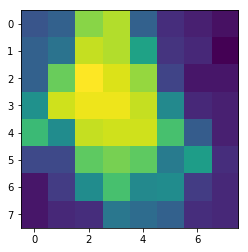

In [218]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data).reshape((TRAINING_FILES*len(class_labels), 8, 8, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data).reshape((TEST_FILES*len(class_labels), 8, 8, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12,:,:,0])
train_data[12,:,:,0]

### CNN model

In [219]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 8, 8, 16)          160       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 128)               0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 387       
Total para

In [220]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

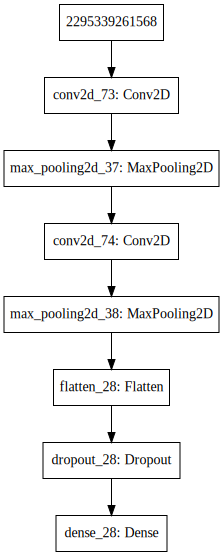

In [221]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [222]:
EPOCHS = 80
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 48 samples, validate on 24 samples
Epoch 1/80
48/48 [==============================] - 2s 38ms/step - loss: 1.1127 - acc: 0.3542 - val_loss: 1.0075 - val_acc: 0.5417
Epoch 2/80
48/48 [==============================] - 0s 403us/step - loss: 0.9915 - acc: 0.5208 - val_loss: 0.9742 - val_acc: 0.7500
Epoch 3/80
48/48 [==============================] - 0s 365us/step - loss: 0.9828 - acc: 0.5208 - val_loss: 0.9440 - val_acc: 0.7500
Epoch 4/80
48/48 [==============================] - 0s 274us/step - loss: 0.9398 - acc: 0.5833 - val_loss: 0.9290 - val_acc: 0.7500
Epoch 5/80
48/48 [==============================] - 0s 238us/step - loss: 0.8509 - acc: 0.8125 - val_loss: 0.9029 - val_acc: 0.7500
Epoch 6/80
48/48 [==============================] - 0s 415us/step - loss: 0.8445 - acc: 0.7083 - val_loss: 0.8736 - val_acc: 0.7500
Epoch 7/80
48/48 [==============================] - 0s 300us/step - loss: 0.9177 - acc: 0.6250 - val_loss: 0.8552 - val_acc: 0.8333
Epoch 8/80
48/48 [===============

48/48 [==============================] - 0s 279us/step - loss: 0.1302 - acc: 1.0000 - val_loss: 0.3632 - val_acc: 0.8750
Epoch 63/80
48/48 [==============================] - 0s 311us/step - loss: 0.1767 - acc: 0.9792 - val_loss: 0.3507 - val_acc: 0.8750
Epoch 64/80
48/48 [==============================] - 0s 331us/step - loss: 0.1467 - acc: 1.0000 - val_loss: 0.3557 - val_acc: 0.8750
Epoch 65/80
48/48 [==============================] - 0s 269us/step - loss: 0.1841 - acc: 0.9792 - val_loss: 0.3393 - val_acc: 0.8750
Epoch 66/80
48/48 [==============================] - 0s 289us/step - loss: 0.1411 - acc: 0.9792 - val_loss: 0.3503 - val_acc: 0.9167
Epoch 67/80
48/48 [==============================] - 0s 258us/step - loss: 0.1459 - acc: 1.0000 - val_loss: 0.3601 - val_acc: 0.8750
Epoch 68/80
48/48 [==============================] - 0s 281us/step - loss: 0.1013 - acc: 1.0000 - val_loss: 0.3603 - val_acc: 0.8750
Epoch 69/80
48/48 [==============================] - 0s 310us/step - loss: 0.1137

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


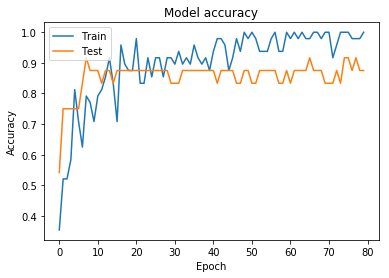

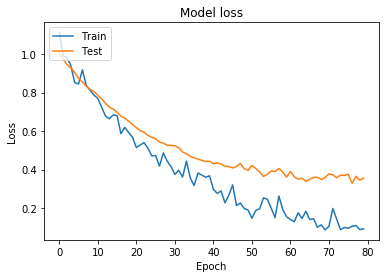

In [223]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [224]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_rock_paper_scissors{}.h5'.format(dt)
model.save(filename)

## Load the model

In [225]:
del model
model = models.load_model(filename)

## Confirmation

In [226]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(48, 8, 8, 1)

In [227]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [228]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [229]:
class_labels

['paper', 'rock', 'scissors']

In [230]:
(activations[-1][:10]*100).astype(int)

array([[97,  2,  0],
       [41, 52,  5],
       [ 1,  0, 98],
       [42, 22, 34],
       [98,  1,  0],
       [ 0,  0, 98],
       [98,  1,  0],
       [88,  1, 10],
       [ 7,  3, 89],
       [ 1, 97,  0]])

In [231]:
test_labels[:10].astype(int)

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [232]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(activations[layer][sample, :, :, i])
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'paper'

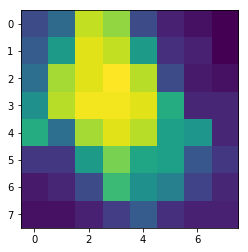

In [233]:
image_number = 10

plt.imshow(test_data[image_number,:,:,0])
class_labels[np.argmax(test_labels[image_number])]

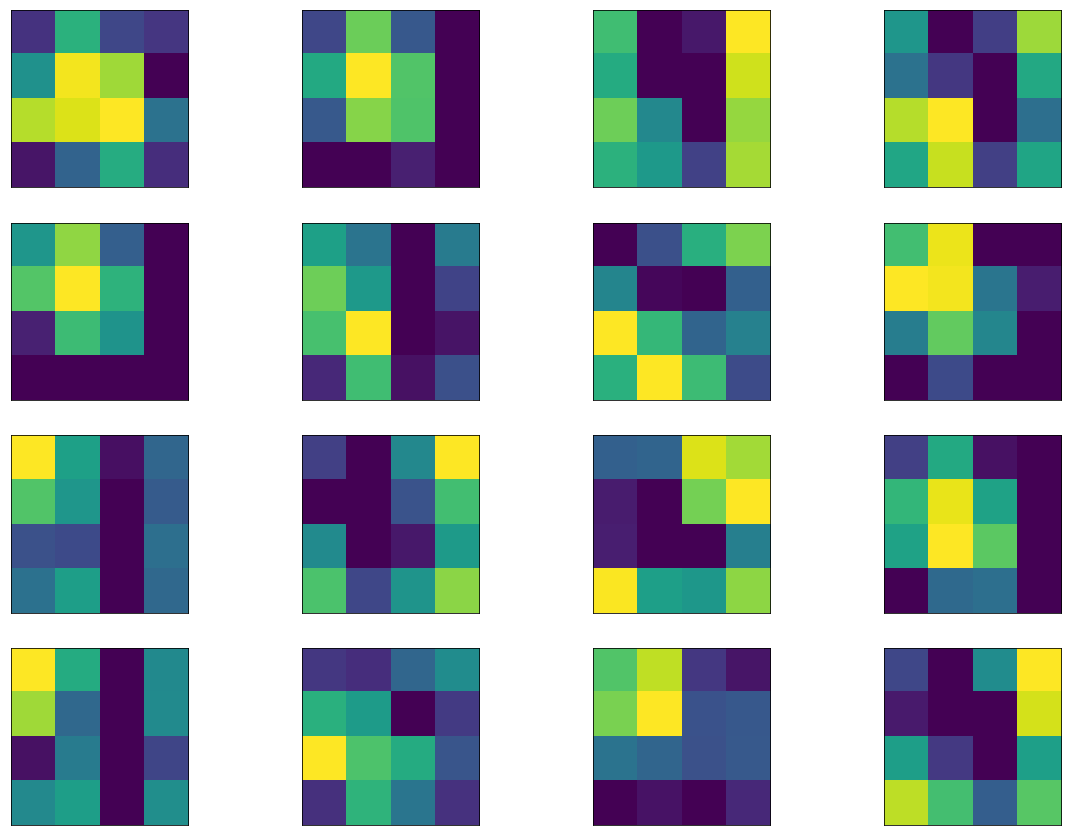

In [234]:
plot_layer(activations, image_number, 1)